In [1]:
import pandas as pd
import numpy as np
import preprocessing as pre

from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.feature_extraction import FeatureHasher

from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV,encontrar_hiperparametros_GSCV, mapear_target_binario

# Naive Bayes

### Obtención de los datos 

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()

### Definiendo distintos preprocesamientos 

In [3]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None):
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    pre.eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion', 'llovieron_hamburguesas_hoy'])
    
    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    return df, imputer

Primer preprocesamiento: Este funcion de preprocesamiento, se compone a su vez por las funciones de preprocesamiento que eliminan features (en este caso, todas las categóricas que por el analisís de la parte 1 vimos que no eran muy relevantes), limpian los datos pasando los missings al tipo NaN de numpy y la feature presión_atmosférica_tarde a float en lugar de string, y finalmente utiliza el imputer iterativo para rellenar missings restantes.

In [4]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, scaler=None):    
    df = df_original.copy(deep=True)
    df = pre.limpiar_datos(df)
    pre.eliminar_features(df, ['dia','barrio'])
    df = pre.aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    df = pre.aplicar_hashing_trick(df, ['direccion_viento_tarde','direccion_viento_temprano','rafaga_viento_max_direccion'], [3,3,3])

    if(imputer is None):
        imputer = pre.entrenar_iterative_imputer(df)
    df = pre.imputar_missings_iterative(df, imputer)
    
    if(scaler is None):
        scaler = pre.entrenar_normalizador_minmax(df)
    df = pre.normalizar_dataframe(df, scaler)
    
    return df, imputer, scaler
    

Segundo preprocesamiento: Limpia datos al igual que en el preprocesamiento primero, aplica dummy variables encoding para llovieron hamburguesas hoy, y en lugar de eliminar las todas las features categoricas irrevelantes, solo elimina el barrio y el dia, y para las direcciones de los vientos y de la rafaga de mayor viento las transforma en un vector de 3 dimensiones mediante hashing trick. Además vuelve a utilizar el imputer iterativo para completar missings, y normaliza los datos entre el rango por defecto del min max scaler (0,1).

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [5]:
X_train_1, imputer_entrenado_1 = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1 = preprocesamiento_1(X_test, imputer_entrenado_1)

In [6]:
X_train_2, imputer_entrenado_2, scaler_entrenado  = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, scaler_entrenado = preprocesamiento_2(X_test, imputer_entrenado_2, scaler_entrenado)

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Buscamos hiperparámetros GridSearch pues al ser un solo hiperparametro limitado a los valores seleccionados, no tendremos problemas de performance y será deterministico. 
* var_smoothing: Porción de la varianza que es añadida a las demás por razones de estabilidad en el cálculo.

In [7]:
params = {'var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]}
hiperparametros = encontrar_hiperparametros_GSCV(GaussianNB(), params=params, x_np=X_train_1, y_np=y_train['llovieron_hamburguesas_al_dia_siguiente'].to_numpy())

suavizado_elegido_1 = hiperparametros['var_smoothing']
print(f'Mejor suavizado: {suavizado_elegido_1}')

Mejor suavizado: 0.0001


### Entrenando el Modelo sobre X_train_1 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos el hiperparámetros encontrado previamente.

In [8]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_1, y_train)):
    naive_bayes_gaussiano = GaussianNB(var_smoothing=suavizado_elegido_1)
    naive_bayes_gaussiano.fit(X_train_1.iloc[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], naive_bayes_gaussiano.predict(X_train_1.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.88      0.88      0.88     15891
   Llueven hamburguesas al dia siguiente       0.59      0.59      0.59      4581

                                accuracy                           0.82     20472
                               macro avg       0.73      0.73      0.73     20472
                            weighted avg       0.82      0.82      0.82     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.90      0.77      0.83     15891
   Llueven hamburguesas al dia siguiente       0.47      0.70      0.56      4580

                                accuracy                           0.76     20471
                               macro avg       0.68      0.74      0.70     20471
                            weighted avg       

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_2

In [9]:
params = {'var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]}
hiperparametros = encontrar_hiperparametros_GSCV(GaussianNB(), params=params, x_np=X_train_2, y_np=y_train.to_numpy().ravel())

suavizado_elegido_2 = hiperparametros['var_smoothing']
print(f'Mejor suavizado: {suavizado_elegido_2}')

Mejor suavizado: 0.0001


### Entrenando el Modelo sobre X_train_2 con CrossValidation

In [10]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_2, y_train)):
    naive_bayes_gaussiano = GaussianNB(var_smoothing=suavizado_elegido_2)
    naive_bayes_gaussiano.fit(X_train_2[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], naive_bayes_gaussiano.predict(X_train_2[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.89      0.88     15891
   Llueven hamburguesas al dia siguiente       0.59      0.55      0.57      4581

                                accuracy                           0.81     20472
                               macro avg       0.73      0.72      0.72     20472
                            weighted avg       0.81      0.81      0.81     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.90      0.80      0.85     15891
   Llueven hamburguesas al dia siguiente       0.50      0.68      0.58      4580

                                accuracy                           0.77     20471
                               macro avg       0.70      0.74      0.71     20471
                            weighted avg       

### Predicción del modelo sobre holdout

Una vez entrenado y validado el modelo con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, debemos elegir uno de ellos para probar en Holdout. Podemos notar si los comparamos, que el promedio del recall de los folds del primero, es bastante mayor al del segundo, que aplico un preprocesamiento mas complejo (0.652 vs 0.628). Sin embargo el modelo que fue entrenado con datos preprocesados de manera mas compleja, da un promedio de la métrica accuracy levemente mayor al del modelo con preprocesamiento mas sencillo (80.2% vs 79.8%). En nuestro caso, valoramos mas el recall ya que por el desbalance de nuestro dataset, es una métrica dificil de maximizar

In [11]:
gnb_holdout = GaussianNB(var_smoothing=suavizado_elegido_1)
gnb_holdout.fit(X_train_1.to_numpy(), y_train.to_numpy().ravel())

GaussianNB(var_smoothing=0.0001)

In [12]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = gnb_holdout.predict(X_test_1.to_numpy())
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = gnb_holdout.predict_proba(X_test_1)[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.89      0.84      0.86      8828
          si       0.54      0.66      0.59      2545

    accuracy                           0.80     11373
   macro avg       0.72      0.75      0.73     11373
weighted avg       0.81      0.80      0.80     11373



### Curva AUC ROC


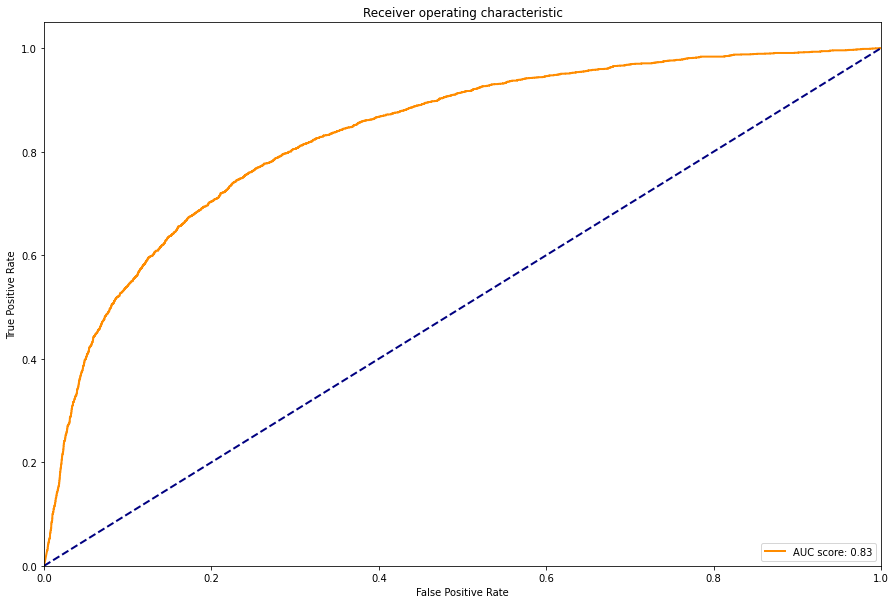

AUC-ROC para este modelo es: 0.8321089220492397


In [13]:
graficar_auc_roc(y_test_binario, y_pred_proba)

### Matriz de confusion

c:\users\juan cruz\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


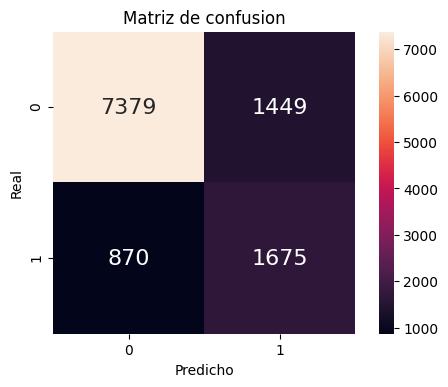

In [14]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el modelo de Naive Bayes Gaussiano sobre el dataset de predicciones nuevo, y la escribimos al archivo 'NaiveBayes.csv'.

In [15]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_GNB([df_prediccion_final])[0]
predicciones = gnb_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'NaiveBayes')

NameError: name 'preprocesamiento_GNB' is not defined